In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
from ipywidgets import IntProgress
from IPython.display import display
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
import pickle
from prettytable import PrettyTable

from codes.BAI_FixedBudget import *
from codes.Environment import Mixture_AbsGau, setup_env, Exp
from codes.SimulatedGames import simulate
from codes.plots import *

%matplotlib inline

In [2]:
rewards_array = np.load('rewards.npy')

In [3]:
class Vaccine_Env():
    """Env for Exponential Distribution.
    """
    def __init__(self, reward):
        self.reward = reward

    def sample(self, size = None):
        return np.random.choice(self.reward)

    def est_hazard_rate(self,bandwidth = 0.005):
        sorted_reward = np.sort(self.reward)
        x_list = np.arange(sorted_reward[0], sorted_reward[-1], 0.01)
        est_h_list = []
        for i, x in enumerate(x_list):
            count1 = 0
            count2 = 0
            for reward in sorted_reward:
                if x <= reward <= x + bandwidth:
                    count1 +=1
                if x<= reward:
                    count2+=1
            est_h = count1/count2/bandwidth
            est_h_list.append(est_h)

        plt.scatter(x_list, est_h_list)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


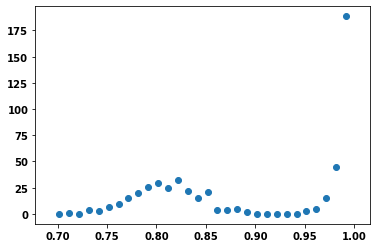

In [4]:
Vaccine_Env(rewards_array[10]).est_hazard_rate()

In [5]:
def setup_env(rewards_array, ss_list = ['quantile_0.5'], random_set = None):
    """Setup environment for Vaccine simulations.
    """
    
    rewards_env = defaultdict(list)
    true_ss_dict = {}

    name = 'vaccine'
    true_ss_dict[name] = defaultdict(list)

    for arm_no, reward in enumerate(rewards_array):
        
        current_env = Vaccine_Env(reward)
                
        rewards_env[name].append(current_env)
                
        for ss in ss_list:
            ss_name = ss.split('_')[0]
            if len(ss.split('_'))> 1:
                ss_para = float(ss.split('_')[-1])
            if ss_name == 'quantile':
                true_ss_dict[name][ss].append(np.quantile(reward, ss_para))
            elif ss_name == 'mean':
                true_ss_dict[name][ss_name].append(np.mean(reward))
            else:
                assert True, 'Unknown summary statistics!'

    return rewards_env, true_ss_dict

0
median:  0.7585
mean:  0.7680238925100001
1
median:  0.767116
mean:  0.77564602245
2
median:  0.775225
mean:  0.78803469408
3
median:  0.7745565
mean:  0.78773167958
4
median:  0.775612
mean:  0.78882768705
5
median:  0.7731129999999999
mean:  0.7834913052200001
6
median:  0.775612
mean:  0.78688506055
7
median:  0.776556
mean:  0.7874538141699999
8
median:  0.832
mean:  0.8491823457999998
9
median:  0.8074905
mean:  0.82401162935
10
median:  0.792802
mean:  0.8081958746200001
11
median:  0.789211
mean:  0.80356375051
12
median:  0.812297
mean:  0.8264946653199999
13
median:  0.7973515
mean:  0.8084246083200001
14
median:  0.789105
mean:  0.8035054574999999
15
median:  0.786357
mean:  0.80088930968
16
median:  0.782
mean:  0.79764478747
17
median:  0.7731699999999999
mean:  0.78434753713
18
median:  0.7765
mean:  0.7890701515800002
19
median:  0.7745
mean:  0.7872946434999999
20
median:  0.778666
mean:  0.79184802109
21
median:  0.774
mean:  0.7866349563599999
22
median:  0.7773055
m

Text(0.5, 1.0, 'Histogram')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


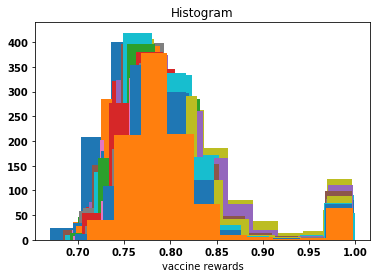

In [6]:
quantile_list = []
mean_list = []
tau = 0.5

for i, reward in enumerate(rewards_array):
    plt.hist(reward)
    quantile_list.append(np.quantile(reward, tau))
    mean_list.append(np.mean(reward))
    print(i)
    print('median: ', np.quantile(reward, tau))
    print('mean: ', np.mean(reward))
plt.xlabel('vaccine rewards')
plt.title('Histogram')

In [7]:
rewards_env, true_ss_dict = setup_env(rewards_array, ['quantile_0.5'])

In [8]:
np.sort(true_ss_dict['vaccine']['quantile_0.5'])

array([0.7585   , 0.767116 , 0.773113 , 0.77317  , 0.774    , 0.7745   ,
       0.7745565, 0.775225 , 0.775612 , 0.775612 , 0.775862 , 0.7765   ,
       0.776556 , 0.7773055, 0.778666 , 0.782    , 0.7861605, 0.786357 ,
       0.789    , 0.789    , 0.789105 , 0.789211 , 0.792104 , 0.792802 ,
       0.7964535, 0.7973515, 0.8056455, 0.806895 , 0.8074905, 0.812297 ,
       0.8215   , 0.832    ])

In [9]:
def run_exper(rewards_env, summary_stats, policy, epsilon, m, budget, num_exper, 
              fixed_samples_list = None):
    for key in rewards_env.keys():
        name = key + '_' + str(num_exper)
        policy_name = str(policy).split('.')[-1].split('\'')[0] + '-'
        subname = policy_name  + str(budget) 
        p = IntProgress(max = num_exper)
        p.description = 'Running'
        display(p)
        results[name][subname] = []

        result = simulate(rewards_env[key],summary_stats[key], policy, 
                epsilon, m, budget, num_exper, p, fixed_samples_list)
        results[name][subname].append(result)

In [10]:

results = defaultdict(dict)

num_exper = 5000
epsilon = 0
m = 3

In [11]:
for budget in [1000, 1250, 1500, 1750, 2000, 2250, 2500, 2750, 3000, 3250, 3500, 3750, 4000]:
# for budget in [500, 750, 1000, 1250, 1500, 1750, 2000, 2250, 2500]:
# for budget in [500]:
    # run_exper(rewards_env, true_ss_dict, Q_SAR_Simplified_Large_Margin, epsilon, m, budget, num_exper)

    # run_exper(rewards_env, true_ss_dict, Q_SAR, epsilon, m, budget, num_exper)
    run_exper(rewards_env, true_ss_dict, Q_SR, epsilon, m, budget, num_exper)

    run_exper(rewards_env, true_ss_dict, Q_SAR_Simplified, epsilon, m, budget, num_exper)

    # run_exper(rewards_env, true_ss_dict, OS_SAR_Simplified, epsilon, m, budget, num_exper)

    run_exper(rewards_env, true_ss_dict, batch_elimination, epsilon, m, budget, num_exper)

    run_exper(rewards_env, true_ss_dict, uniform_sampling, epsilon, m, budget, num_exper)

IntProgress(value=0, description='Running', max=5000)

IntProgress(value=0, description='Running', max=5000)

IntProgress(value=0, description='Running', max=5000)

IntProgress(value=0, description='Running', max=5000)

IntProgress(value=0, description='Running', max=5000)

IntProgress(value=0, description='Running', max=5000)

KeyboardInterrupt: 

Budget  Probability of Error       std     Policy
0   1000                 0.361  0.048029      Q-SAR
1   1000                 0.439  0.049627       Q-SR
2   1000                 0.639  0.048029       Q-BS
3   1000                 0.638  0.048058  Q-Uniform
4   1250                 0.305  0.046041      Q-SAR


,Budget,Probability of Error,std,Policy
0,1000,0.361,0.048029,Q-SAR
1,1000,0.439,0.049627,Q-SR
2,1000,0.639,0.048029,Q-BS
3,1000,0.638,0.048058,Q-Uniform
4,1250,0.305,0.046041,Q-SAR
5,1250,0.390,0.048775,Q-SR
6,1250,0.499,0.050000,Q-BS
7,1250,0.596,0.049070,Q-Uniform
8,1500,0.272,0.044499,Q-SAR
9,1500,0.334,0.047164,Q-SR


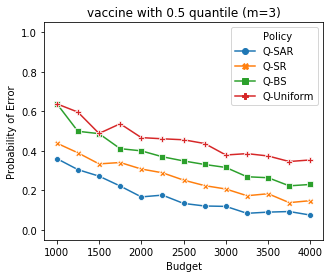

In [15]:
# save results

with open('../vaccine_m3_05quant_exper_5000.pickle', 'wb') as handle:
     pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('../Group_One_Fixed_Budget.pickle', 'rb') as handle:
#     results = pickle.load(handle)

plot_eva_budget(results, 'pe', paper_flag = True, with_para = True, title = 'vaccine with 0.5 quantile (m=3)', log_scale = False)